In [1]:
%pip install scipy
%pip install numpy
%pip install matplotlib

   ---------------------------------------- 0.0/41.0 MB ? eta -:--:--
    --------------------------------------- 0.5/41.0 MB 4.2 MB/s eta 0:00:10
   - -------------------------------------- 1.6/41.0 MB 4.2 MB/s eta 0:00:10
   -- ------------------------------------- 2.4/41.0 MB 4.1 MB/s eta 0:00:10
   --- ------------------------------------ 3.4/41.0 MB 4.1 MB/s eta 0:00:10
   ---- ----------------------------------- 4.2/41.0 MB 4.1 MB/s eta 0:00:09
   ---- ----------------------------------- 5.0/41.0 MB 4.0 MB/s eta 0:00:10
   ----- ---------------------------------- 5.8/41.0 MB 4.1 MB/s eta 0:00:09
   ------ --------------------------------- 6.8/41.0 MB 4.2 MB/s eta 0:00:09
   ------- -------------------------------- 7.6/41.0 MB 4.2 MB/s eta 0:00:09
   -------- ------------------------------- 8.7/41.0 MB 4.2 MB/s eta 0:00:08
   --------- ------------------------------ 9.7/41.0 MB 4.2 MB/s eta 0:00:08
   ---------- ----------------------------- 10.5/41.0 MB 4.2 MB/s eta 0:00:08
   --

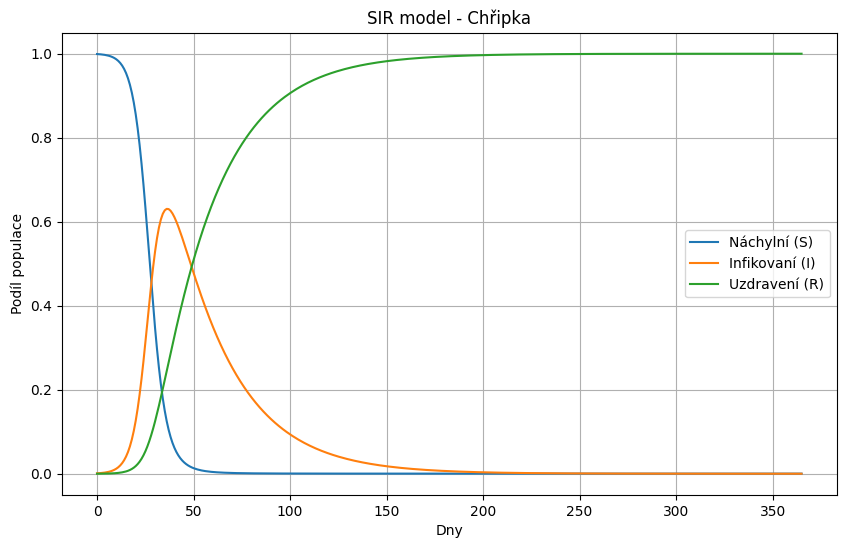

--------------------------------------------------
Vrchol epidemie nastává přibližně v den: 36.1
Epidemie prakticky končí kolem dne: 365.0
Celkový počet nakažených jedinců: 1,000
Počet jedinců, kteří se nenakazili: 0
--------------------------------------------------



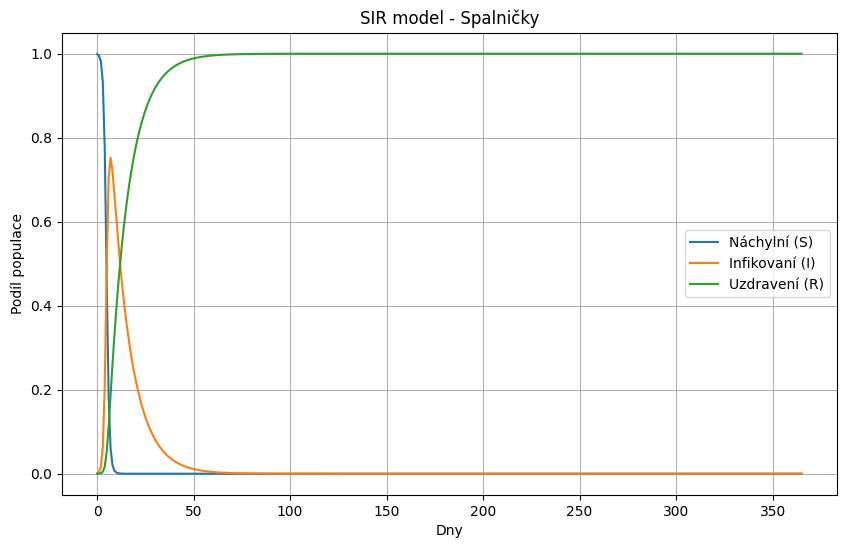

--------------------------------------------------
Vrchol epidemie nastává přibližně v den: 7.0
Epidemie prakticky končí kolem dne: 120.3
Celkový počet nakažených jedinců: 1,000
Počet jedinců, kteří se nenakazili: 0
--------------------------------------------------



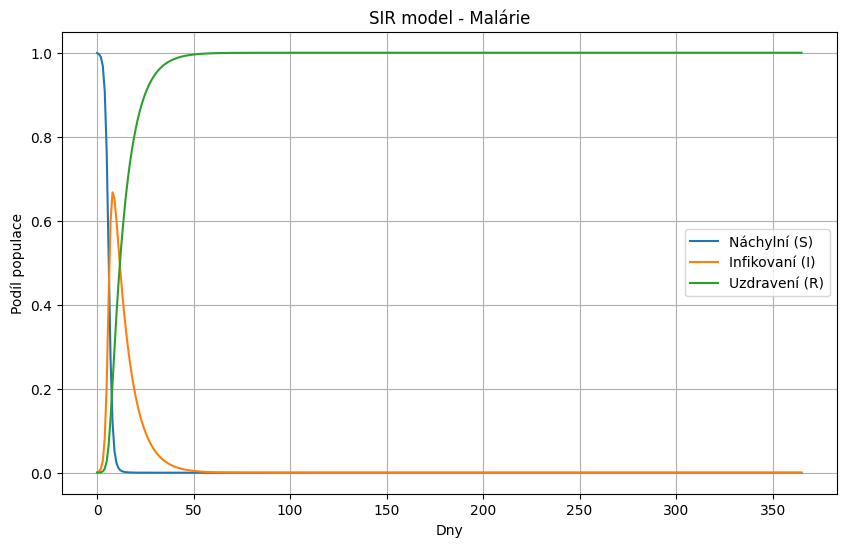

--------------------------------------------------
Vrchol epidemie nastává přibližně v den: 8.0
Epidemie prakticky končí kolem dne: 99.3
Celkový počet nakažených jedinců: 1,000
Počet jedinců, kteří se nenakazili: 0
--------------------------------------------------



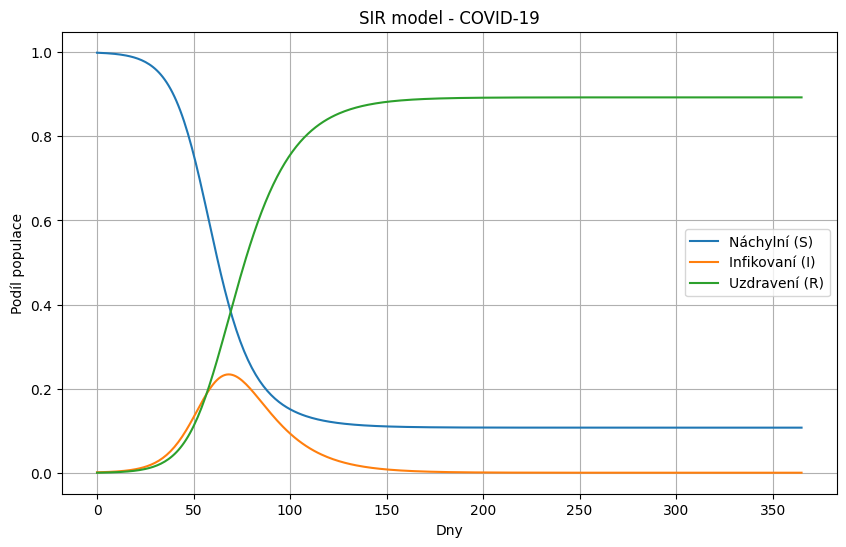

--------------------------------------------------
Vrchol epidemie nastává přibližně v den: 68.2
Epidemie prakticky končí kolem dne: 277.8
Celkový počet nakažených jedinců: 893
Počet jedinců, kteří se nenakazili: 107
--------------------------------------------------



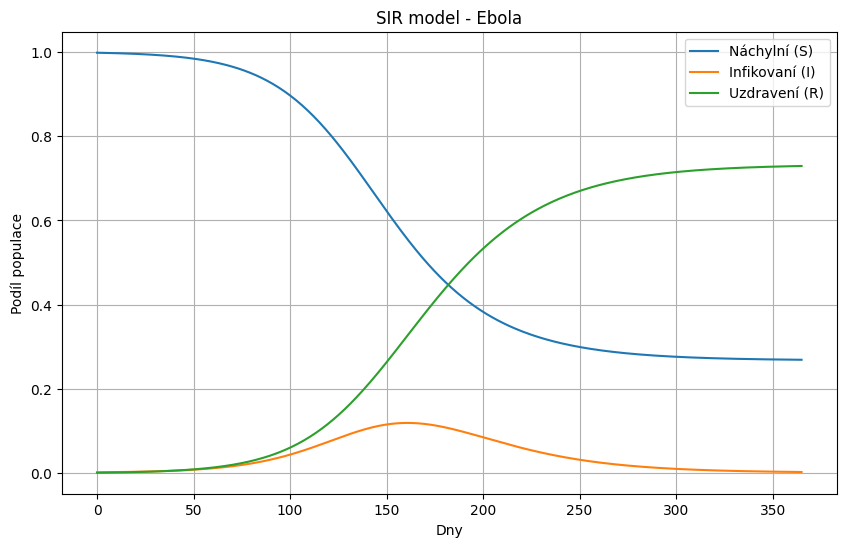

--------------------------------------------------
Vrchol epidemie nastává přibližně v den: 160.4
Epidemie prakticky končí kolem dne: 365.0
Celkový počet nakažených jedinců: 730
Počet jedinců, kteří se nenakazili: 269
--------------------------------------------------



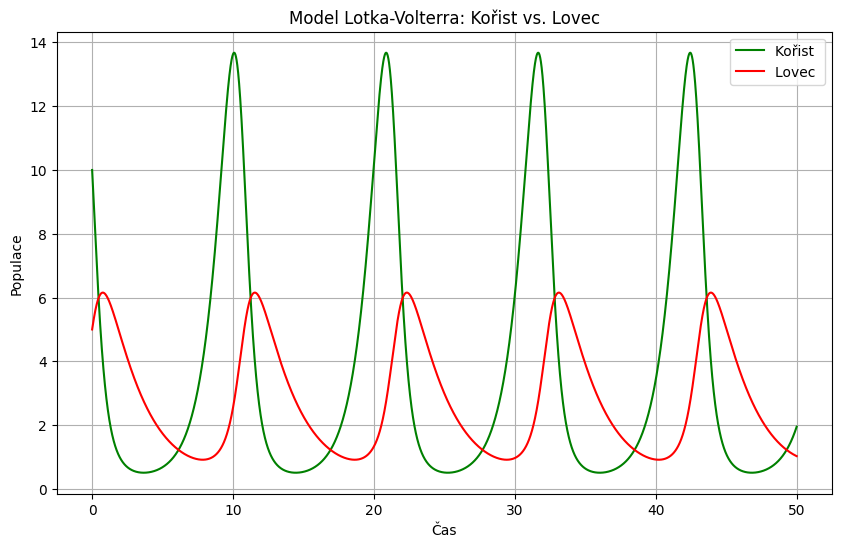

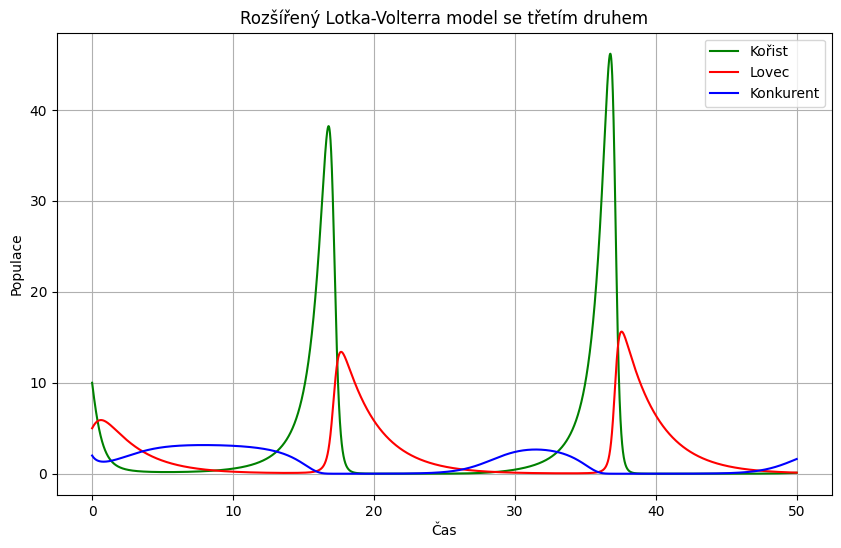

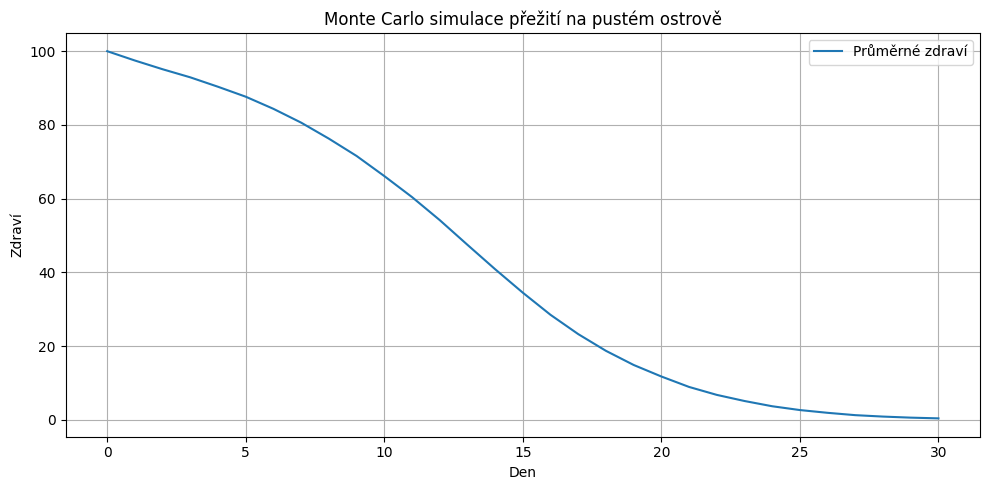

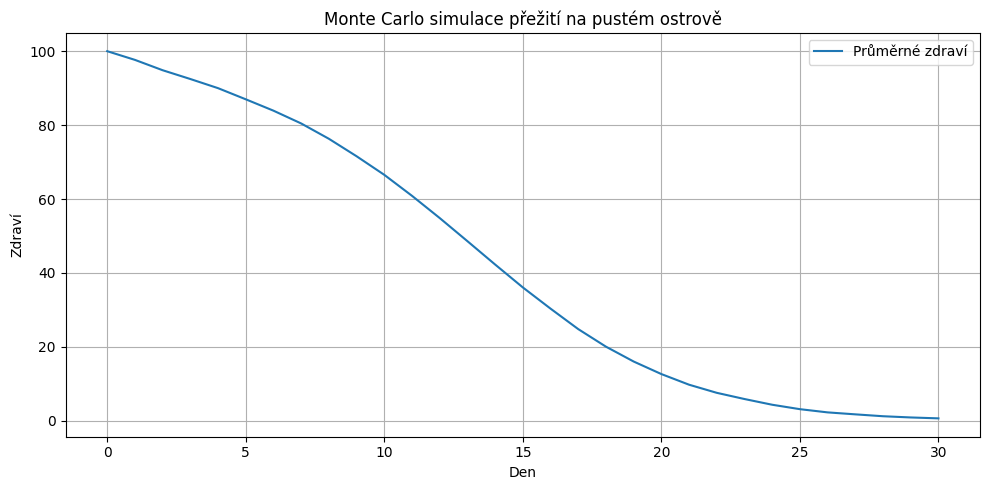

In [ ]:
from abc import ABC, abstractmethod
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

class Model(ABC):
    
    @abstractmethod
    def run_simulation(self):
        pass
    
models: list[Model] = []

class SirModel(Model):
    def __init__(self, N: int, I0: int, R0: int, reproduction: float, infectious_days: int, disease: str):
        super().__init__()
        self.N = N                                          #Počet populace
        self.I0 = I0                                        #Počáteční stav nakažených
        self.R0 = R0                                        #Počáteční stav imunních
        self.S0 = N - I0 - R0                               #Počet náchylných
        self.timeline = np.linspace(0, 365, 365)            #Časová osa
        self.gamma = 1.0 / infectious_days                  #Výpočet gammy, která udává jak rychle se jedinec vyléčí
        self.beta = self.gamma * reproduction               #Výpočet bety, která udává jak rychle se infekce šíří

        self.y0 = self.S0 / N, self.I0 / N, self.R0 / N     #Počáteční vektor pro začátek simulace
        self.disease = disease                              #Název nemoci pro grafy a výstupy
    
    
    def _derivation(self, y0, t, beta, gamma):
        S, I, R = y0
        dSdt =  -beta * S * I                               #pokles vnímavých díky infekci
        dIdt = beta * S * I - gamma * I                     #růst a pokles nakažených
        dRdt = gamma * I                                    #růst uzdravených
        return dSdt, dIdt, dRdt
    
    
    def run_simulation(self):
        
        result = odeint(self._derivation, self.y0, self.timeline, args=(self.beta, self.gamma))
        S, I, R = result.T

        # Graf
        plt.figure(figsize=(10, 6))
        plt.plot(self.timeline, S, label='Náchylní (S)')
        plt.plot(self.timeline, I, label='Infikovaní (I)')
        plt.plot(self.timeline, R, label='Uzdravení (R)')
        plt.xlabel('Dny')
        plt.ylabel('Podíl populace')
        plt.title(f'SIR model - {self.disease}')
        plt.legend()
        plt.grid()
        plt.show()
        
        #Vrchol epidemie – den, kdy je nejvíce nakažených
        peak_day = self.timeline[np.argmax(I)]

        #Konec epidemie – když počet nakažených klesne pod prahovou hodnotu
        end_day = next((self.timeline[i] for i in range(len(I)-1) if I[i] < 1e-5 and I[i+1] < 1e-5), self.timeline[-1])

        #Počet nakažených a nenakažených jedinců
        infected = R[-1] * self.N          # uzdravení = byli nakažení
        uninfected = S[-1] * self.N         # vnímaví = nikdy neonemocněli 
        
        print("--------------------------------------------------")
        print(f"Vrchol epidemie nastává přibližně v den: {peak_day:.1f}")
        print(f"Epidemie prakticky končí kolem dne: {end_day:.1f}")
        print(f"Celkový počet nakažených jedinců: {infected:,.0f}")
        print(f"Počet jedinců, kteří se nenakazili: {uninfected:,.0f}")
        print("--------------------------------------------------\n")
        
diseases = {
    "Chřipka": (8.5, 30),
    "Spalničky": (15, 10),
    "Malárie": (10, 8),
    "COVID-19": (2.5, 14),
    "Ebola": (1.8, 20)
}   




for k, v in diseases.items():
    model = SirModel(1000, 1,0, v[0], v[1], k)
    models.append(model)
    
    
    

class LVModel(Model):
    def __init__(self, alpha: float, beta: float, delta: float, gamma: float, counts: list):
        super().__init__()
        self.alpha = alpha                      #Růst kořisti
        self.beta = beta                        #Míra predace (vliv lovců na kořist)
        self.delta = delta                      #Přeměna kořisti na predátori
        self.gamma = gamma                      #Úmrtnost predátorů
        self.counts = counts                    #Počty kořisti a predatora
        self.timeline = np.linspace(0,50,100000)
        
    def _derivation(self, counts, t):
        pass

    def run_simulation(self):
        pass
        
        
class LVModel2(LVModel):
    def __init__(self, alpha, beta, delta, gamma, counts):
        super().__init__(alpha, beta, delta, gamma, counts)
        
    
    def _derivation(self, counts, t):
        prey, predator = counts
        dprey_dt = self.alpha * prey - self.beta * prey * predator
        dpredator_dt = self.delta * prey * predator - self.gamma * predator
        return [dprey_dt, dpredator_dt]

    def run_simulation(self):
        solution = odeint(self._derivation, self.counts, self.timeline)
        prey, predator = solution.T
        plt.figure(figsize=(10, 6))
        plt.plot(self.timeline, prey, label='Kořist ', color='green')
        plt.plot(self.timeline, predator, label='Lovec ', color='red')
        plt.title('Model Lotka-Volterra: Kořist vs. Lovec')
        plt.xlabel('Čas')
        plt.ylabel('Populace')
        plt.legend() # legenda
        plt.grid() # mřížka
        plt.show() # Zobrazit graf
        
        
class LVModel3(LVModel):
    def __init__(self, alpha, beta, delta, gamma, epsilon: float, zeta: float, eta: float, counts):
        super().__init__(alpha, beta, delta, gamma, counts)
        self.epsilon = epsilon                      # růstová rychlost konkurenta
        self.zeta = zeta                            # kompetice mezi kořistí a konkurentem
        self.eta = eta                              # vliv kořisti na konkurenta
        
        
    def _derivation(self, counts, t):
        prey, predator, competitor = counts
        dprey_dt = self.alpha * prey - self.beta * prey * predator - self.eta * prey * competitor  # Rovnice pro kořist
        dpredator_dt = self.delta * prey * predator - self.gamma * predator # Rovnice pro predátora
        dcompetitor_dt = self.epsilon * competitor * (1 - self.zeta * competitor - self.eta * prey) # Rovnice pro konkurenta
        return [dprey_dt, dpredator_dt, dcompetitor_dt]

    def run_simulation(self):
        solution = odeint(self._derivation, self.counts, self.timeline)
        prey, predator, competitor = solution.T
        plt.figure(figsize=(10, 6))
        plt.plot(self.timeline, prey, label='Kořist', color='green')
        plt.plot(self.timeline, predator, label='Lovec', color='red')
        plt.plot(self.timeline, competitor, label='Konkurent', color='blue')

        plt.title('Rozšířený Lotka-Volterra model se třetím druhem')
        plt.xlabel('Čas')
        plt.ylabel('Populace')
        plt.legend()
        plt.grid()
        plt.show()    

models.append(LVModel2(1.1, 0.4, 0.1, 0.4, [10,5]))
models.append(LVModel3(1.1, 0.4, 0.1, 0.4, 0.8, 0.3, 0.2, [10, 5, 2]))




class MonteCarloModel(Model):
    def __init__(self, days: int, simulation_count: int):
        super().__init__()
        self.days = days                      # Počet dní simulace
        self.results = []                     # Výsledky simulace    
        self.simulation_count = simulation_count # Počet simulací

    def run_simulation(self):
        for _ in range(self.simulation_count):
            water = 100       # počáteční zásoba vody
            food = 5        # počáteční zásoba jídla
            fatigue = 0     # počáteční únava
            health = 100    # počáteční zdraví
            daily_health = [health]

            for day in range(self.days):
                # Náhodná denní událost
                event = np.random.choice(['nothing', 'rain', 'animal', 'find_food'], p=[0.5, 0.2, 0.2, 0.1])
                # Náhodné rozhodnutí
                action = np.random.choice(['rest', 'forage', 'hunt'])

                # Události
                if event == 'rain':
                    water += 1
                elif event == 'animal':
                    health -= np.random.randint(5, 20)
                elif event == 'find_food':
                    food += 2

                # Akce dne
                if action == 'rest':
                    fatigue = max(fatigue - 1, 0)
                elif action == 'forage':
                    food += 1
                    fatigue += 1
                elif action == 'hunt':
                    food += 2
                    fatigue += 2

                # Denní spotřeba
                water -= 1
                food -= 1

                # Tresty za nedostatek
                if water < 0:
                    health -= 10
                    water = 0
                if food < 0:
                    health -= 5
                    food = 0
                if fatigue > 5:
                    health -= fatigue - 5

                # Konec, pokud zemře
                if health <= 0:
                    daily_health.append(0)
                    break

                daily_health.append(health)

            # Pokud zemřel dřív, doplníme nuly do zbytku dnů
            while len(daily_health) < self.days + 1:
                daily_health.append(0)

            self.results.append(daily_health)

        # Výpočet průměrného zdraví v každém dni (ze všech běhů)
        average_health = np.mean(self.results, axis=0)

        # Vykreslení grafu
        plt.figure(figsize=(10, 5))
        plt.plot(average_health, label='Průměrné zdraví')
        plt.xlabel('Den')
        plt.ylabel('Zdraví')
        plt.title('Monte Carlo simulace přežití na pustém ostrově')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

models.append(MonteCarloModel(30, 1000))
models.append(MonteCarloModel(30, 10000))

for model in models:
    model.run_simulation()